In [1]:
from src.load_balancer.simulation import simulation_cli

In [2]:
sad = await simulation_cli(num_servers=2,server_buffer_size=2,server_mu=0.04,lambda_=50,simulation_time=3,routing_fn='shortest_queue')


Start symulacji - polityka route_shortest_queue


00:00:232 | INFO | [WS1] ✅ Processed request   0 (0.04s)
00:00:278 | INFO | [WS1] ❌ Rejected  request   7 (queue full)
00:00:283 | INFO | [WS1] ✅ Processed request   1 (0.05s)
00:00:321 | INFO | [WS2] ✅ Processed request   2 (0.12s)
00:00:334 | INFO | [WS1] ❌ Rejected  request  10 (queue full)
00:00:336 | INFO | [WS2] ✅ Processed request   4 (0.01s)
00:00:362 | INFO | [WS1] ❌ Rejected  request  12 (queue full)
00:00:369 | INFO | [WS1] ❌ Rejected  request  13 (queue full)
00:00:377 | INFO | [WS1] ✅ Processed request   3 (0.09s)
00:00:383 | INFO | [WS1] ✅ Processed request   5 (0.00s)
00:00:401 | INFO | [WS1] ✅ Processed request   8 (0.02s)
00:00:456 | INFO | [WS1] ✅ Processed request  14 (0.03s)
00:00:487 | INFO | [WS2] ✅ Processed request   6 (0.15s)
00:00:555 | INFO | [WS1] ❌ Rejected  request  19 (queue full)
00:00:570 | INFO | [WS1] ❌ Rejected  request  20 (queue full)
00:00:610 | INFO | [WS1] ❌ Rejected  request  21 (queue full)
00:00:614 | INFO | [WS1] ✅ Processed request  15 (0.1


Polityka: route_shortest_queue
Przetworzone zgłoszenia: 102
Odrzucone zgłoszenia: 27
Zgłoszenia w kolejkach: 2


In [3]:
import json
import pandas as pd

def process_queue_data(file_path):
    with open(file_path) as file:
        data = json.load(file)
    
    data_df = pd.DataFrame(data)
    
    def convert_to_ms(timestamp):
        m, s, ms = timestamp.split(':')
        total_ms = (int(m) * 60 * 1000) + (int(s) * 1000) + int(ms)
        return round(total_ms, 5)
    
    data_df['ts_in_ms'] = data_df['ts'].apply(convert_to_ms)
    
    queue_count = {}
    
    data_df['currently_in_queue'] = 0

    for index, row in data_df.iterrows():
        source = row['source']
        status = row['status']
        
        if source not in queue_count:
            queue_count[source] = 0
        
        if status == 'queued':
            queue_count[source] += 1
        elif status == 'processed':
            queue_count[source] -= 1
        
        data_df.at[index, 'currently_in_queue'] = queue_count[source]
    
    queued_df = data_df[data_df['status'] == 'queued']
    processed_df = data_df[data_df['status'] == 'processed']
    
    merged_df = pd.merge(queued_df, processed_df, on='request', suffixes=('_queued', '_processed'))
    
    merged_df['processing_time_ms'] = merged_df['ts_in_ms_processed'] - merged_df['ts_in_ms_queued']
    
    result = merged_df[['request', 'ts_queued', 'ts_processed', 'processing_time_ms', 'source_queued']]
    rejects = data_df[data_df['status'] == 'rejected']
    
    return data_df, result, rejects

# Example usage:
file_path = '.logs/route_shortest_queue_0.json'
data_df, result, rejects = process_queue_data(file_path)

print(result)
print(rejects)


     request  ts_queued ts_processed  processing_time_ms source_queued
0          0  00:00:000    00:00:011                  11           WS1
1          1  00:00:032    00:00:126                  94           WS1
2          2  00:00:051    00:00:179                 128           WS1
3          5  00:00:131    00:00:189                  58           WS1
4          6  00:00:204    00:00:208                   4           WS1
..       ...        ...          ...                 ...           ...
126      129  00:02:582    00:02:677                  95           WS2
127      130  00:02:614    00:02:678                  64           WS2
128      138  00:02:710    00:02:917                 207           WS2
129      142  00:02:827    00:02:955                 128           WS2
130      146  00:02:947    00:02:966                  19           WS2

[131 rows x 5 columns]
            ts source  request    status  ts_in_ms  currently_in_queue
41   00:00:861    WS1       37  rejected       861   

In [14]:
df_a = data_df[data_df['source'] == 'WS2']
df_a['ts_in_ms'].values[0] * df_a['ts_in_ms'].values[1]

np.int64(13542)

In [21]:
# % zapełnienia kolejki

avg_queue = 0
temp_sum = 0

df_a = data_df[data_df['source'] == 'WS1']
for idx in range(df_a.shape[0]-1):
    temp_sum += (df_a['ts_in_ms'].values[idx+1] - df_a['ts_in_ms'].values[idx]) * df_a['currently_in_queue'].values[idx]
temp_sum = temp_sum / df_a['ts_in_ms'].values[-1] / 3
temp_sum


np.float64(0.6569870939029817)

In [4]:

data_df[data_df['source'] == 'WS2']


,ts,source,request,status,ts_in_ms,currently_in_queue
168,00:00:111,WS2,3,queued,111,1
169,00:00:122,WS2,4,queued,122,2
170,00:00:221,WS2,3,processed,221,1
171,00:00:293,WS2,9,queued,293,2
172,00:00:298,WS2,4,processed,298,1
...,...,...,...,...,...,...
277,00:02:947,WS2,146,queued,2947,2
278,00:02:955,WS2,142,processed,2955,1
279,00:02:966,WS2,146,processed,2966,0
280,00:02:976,WS2,148,queued,2976,1


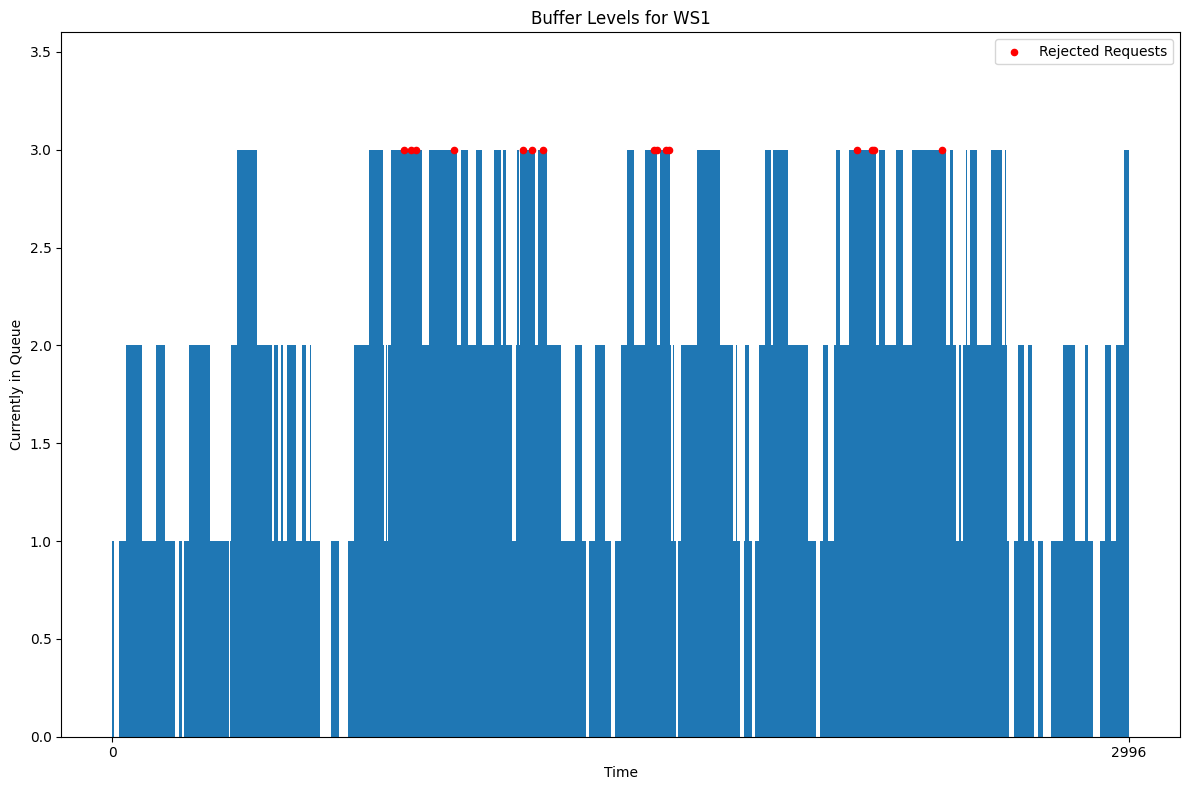

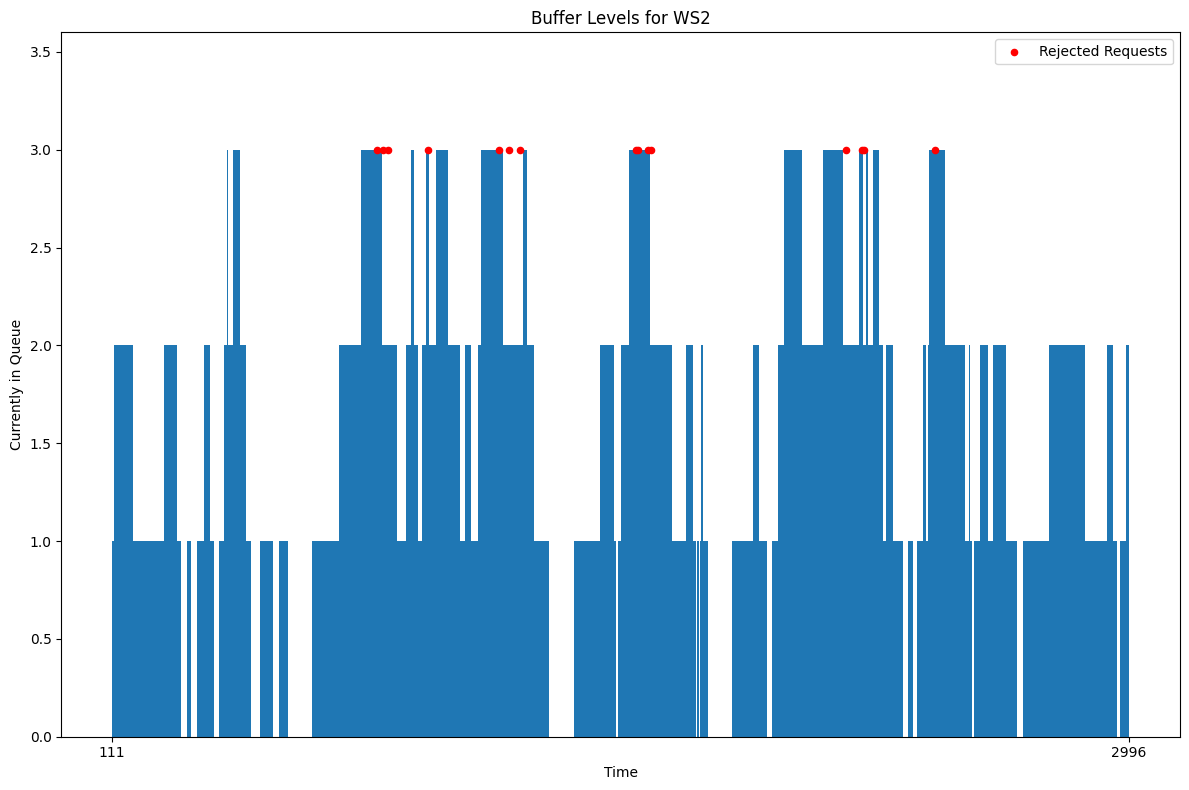

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_buffer_levels(data_df, rejects, max_buffer):
    # Get unique sources from the DataFrame
    unique_sources = data_df['source'].unique()
    
    # Iterate through each source to create the plots
    for source in unique_sources:
        # Filter the data for the current source
        source_data = data_df[data_df['source'] == source]
        
        # Create a new figure for each source
        plt.figure(figsize=(12, 8))
        
        # Step plot for currently in queue
        plt.step(source_data['ts_in_ms'], source_data['currently_in_queue'], where='mid', alpha=0)
        plt.fill_between(source_data['ts_in_ms'], source_data['currently_in_queue'], step='mid')

        # Set the limits for the y-axis
        plt.ylim(0, max_buffer*1.2)
        
        # Scatter plot for rejected requests
        plt.scatter(rejects['ts_in_ms'], np.ones(len(rejects)) * max_buffer, 
                    color='red', s=20, label='Rejected Requests')

        # Set title and labels
        plt.title(f'Buffer Levels for {source}')
        plt.xlabel('Time')
        plt.ylabel('Currently in Queue')
        plt.legend()
        
        # Set x-axis ticks
        plt.xticks([np.min(source_data['ts_in_ms']), np.max(source_data['ts_in_ms'])])
        
        # Show the plot
        plt.tight_layout()
        plt.show()

# Example usage
max_buffer = 3  # Set the maximum buffer level as needed
plot_buffer_levels(data_df, rejects, max_buffer)


/tmp/ipykernel_11582/356661598.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_sources)


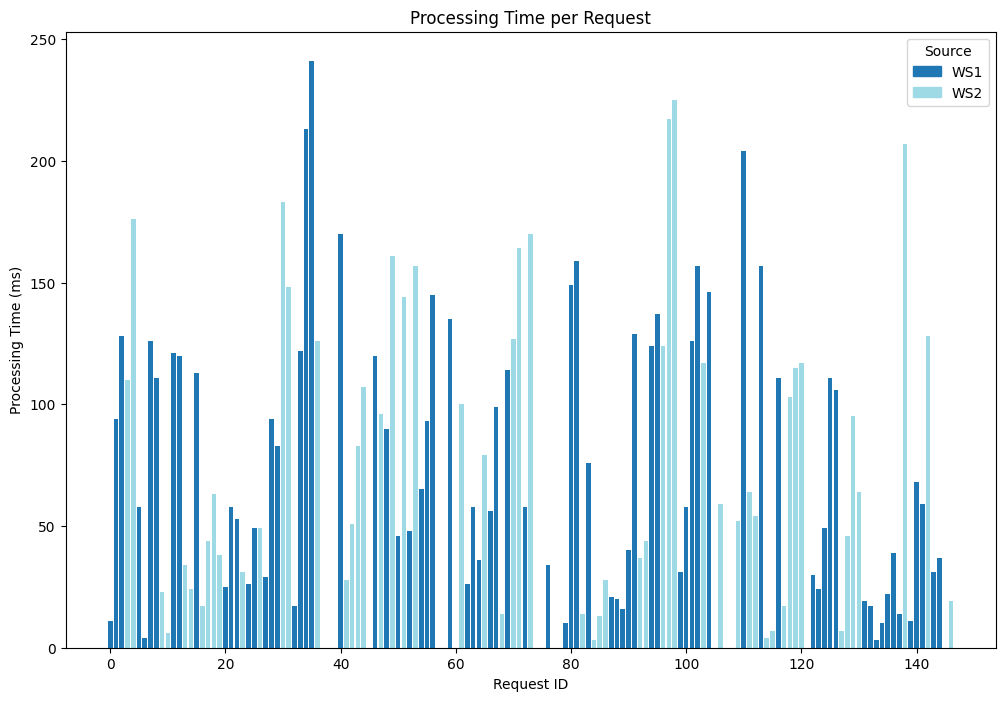

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_processing_times(merged_df):
    unique_sources = merged_df['source_queued'].unique()
    num_sources = len(unique_sources)

    cmap = cm.get_cmap('tab20', num_sources)  
    color_mapping = {source: cmap(i) for i, source in enumerate(unique_sources)}

    colors = merged_df['source_queued'].map(color_mapping)
    

    fig = plt.figure(figsize=[12, 8])
    plt.bar(merged_df['request'], merged_df['processing_time_ms'], color=colors)

    plt.xlabel('Request ID')
    plt.ylabel('Processing Time (ms)')
    plt.title('Processing Time per Request')
    

    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[source]) for source in unique_sources]
    plt.legend(handles, unique_sources, title="Source")
    plt.show()

plot_processing_times(result)